# Determining Optimal Gate Bias 

In [1]:
import qcodes as qc
import numpy as np
from time import sleep

import sweep 
from sweep.sweep_load import pload1d
from barreralabdrivers.utils.param_utils import paramp
from cappy.config import dualhemtconfig, data2path
from cappy.balancer import Balancer

from qcodes.validators import Numbers, Callable, Validator
from qcodes.parameters import Parameter, ScaledParameter
import datetime

In [2]:
qc.Instrument.close_all()   # in case of existing connecitons
container = qc.Station(config_file=str(dualhemtconfig))

acdac = container.load_instrument("acdac")
dcdac = container.load_instrument("dcdac")
yoko = container.load_instrument("yoko")
keithley = container.load_instrument("keithley")
li1 = container.load_instrument("lockin")

print(100 * "-")
print(f"{datetime.datetime.now().strftime('%c')}")

Connected to: BARRERA ACDAC02 (serial:AD9106, firmware:2.00) in 3.08s
Connected to: BARRERA DCDAC01 (serial:AD5764, firmware:2.00) in 3.06s
Connected to: YOKOGAWA 765611 (serial:90ZC43353, firmware:1.10) in 0.02s
Connected to: KEITHLEY INSTRUMENTS DMM6500 (serial:04608216, firmware:1.7.12b) in 0.01s
Connected to: Stanford_Research_Systems SR865A (serial:005296, firmware:V1.51) in 0.09s
----------------------------------------------------------------------------------------------------
Thu Feb  6 17:07:03 2025


In [3]:
# Applied AC Voltages
Vref = acdac.ch1
V1pf = acdac.ch2
Vlref = acdac.ch3

# Applied DC Voltages
Vdd = yoko.channel1.voltage             # drives darin to source current across HEMT_A 
Vgamp = dcdac.channel1.voltage          # drives drain to source current across HEMT_R draining at HEMT_A gate 
Vgres = yoko.channel2.voltage           # gate voltage on HEMT_R 


# validators
non_positive_validator = Numbers(min_value=-2 , max_value=0)      
vg_max_validator = Numbers(min_value = -2, max_value=Vgamp.get())

# Vgamp < 0 and Vgres < Vgramp at all times 
Vgamp.add_validator(non_positive_validator)  
Vgres.add_validator(vg_max_validator)

# Measured Quantities 
Vdsdc = keithley.amplitude
Vdsac_R = li1.R
Vdsac_P = li1.P

## Helper Functions

In [4]:
def sys_paramp():
    print("Ramping down Vgamp ...")
    paramp(Vgamp) 
    print("Ramping down ac voltages ...")
    paramp((V1pf.voltage, Vref.voltage, Vlref.voltage), sleep_time=0.1)
    print("Ramping down Vdd and Vgres ...")
    paramp((Vdd,Vgres))
    print("System shut down")

def toggle_yoko(on=True):
    mode = 1 if on else 0
    yoko.channel1.output(mode)
    yoko.channel2.output(mode)

## Jan 30 

In [16]:
def Vgamp_set(value):
    """
        Use this function to set Vgamp to value and update validator for Vgres. DO NOT set Vgamp natively. 
    """
    curr_Vgres = Vgres()
    if curr_Vgres > value:
        # update validator 
        vg_max_validator = Numbers(min_value = -3, max_value=value)
        Vgres.remove_validator()
        Vgres.add_validator(vg_max_validator)

        # set Vgamp and Vgres
        Vgres(value - 0.1)
        sleep(0.2)

    Vgamp(value)

def vgres_valid(val):
    vgamp = Vgamp()
    return vgamp - 0.5 <= val and val <=  vgamp 

# TODO:
numbertypes = float | int | np.floating | np.integer
class GateValidator(Validator[numbertypes]):
    """
    Requires a number  of type int, float, numpy.integer or numpy.floating.

    Args:
        min_value: Minimal value allowed, default -inf.
        max_value: Maximal value allowed, default inf.

    Raises:
        TypeError: If min or max value not a number. Or if min_value is
            larger than the max_value.

    """

    validtypes = (float, int, np.integer, np.floating)

    def __init__(self) -> None:
        if isinstance(min_value, self.validtypes):
            self._min_value = min_value
        else:
            raise TypeError("min_value must be a number")

        valuesok = max_value > min_value

        if isinstance(max_value, self.validtypes) and valuesok:
            self._max_value = max_value
        else:
            raise TypeError("max_value must be a number bigger than min_value")

        self._valid_values = (min_value, max_value)

    def validate(self, value: numbertypes, context: str = "") -> None:
        """
        Validate if number else raises error.

        Args:
            value: A number.
            context: Context for validation.

        Raises:
            TypeError: If not int or float.
            ValueError: If number is not between the min and the max value.

        """
        if not isinstance(value, self.validtypes):
            raise TypeError(f"{value!r} is not an int or float; {context}")

        if not (self._min_value <= value <= self._max_value):
            raise ValueError(
                f"{value!r} is invalid: must be between "
                f"{self._min_value} and {self._max_value} inclusive; {context}"
            )

    is_numeric = True

    def __repr__(self) -> str:
        minv = self._min_value if math.isfinite(self._min_value) else None
        maxv = self._max_value if math.isfinite(self._max_value) else None
        return "<Numbers{}>".format(range_str(minv, maxv, "v"))

    @property
    def min_value(self) -> float:
        return float(self._min_value)

    @property
    def max_value(self) -> float:
        return float(self._max_value)
    

In [6]:
acdac.display_mode("NORMAL")

In [7]:
def toggle_yoko(on=True):
    mode = 1 if on else 0
    yoko.channel1.output(mode)
    yoko.channel2.output(mode)

toggle_yoko()



In [58]:
Vgres(-0.1)

In [59]:
Vgres(-0.2)

In [60]:
Vgres(-0.3)

In [33]:
Vlref.voltage(200)
V1pf.voltage(100)
Vref.voltage(0)

In [39]:
Vgres.remove_validator()
Vgres.validators

(<Numbers -2<=v<=0>,)

In [40]:
Vgres(-0.5)

In [41]:
Vgamp(-0.4)

In [43]:
Vdd(0.1)

In [44]:
Vgres(-1)

In [46]:
Vgamp(-0.7)

In [47]:
paramp((Vgamp, Vdd))

In [48]:
paramp(Vgres)

In [49]:
Vgamp()

VisaIOError: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking 'channel1:VOLTAGE?' to <DCDAC5764: dcdac>", 'getting dcdac_channel1_voltage')

In [ ]:
# measurement config for analysis 
indep_params = [Vgamp]
dep_params = [, Gout.R, Gout.P]
mc = {}
for param in indep_params + dep_params:
    mc[param.full_name] = param.label

s = sweep.Station(basedir=datapath, measurement_config=mc)
for param in indep_params + dep_params:
    s.fp(param)

s.add_comment("Vg sweep")

## Jan 28th Notes 
    Vds (pin 20) wasn't reading voltage. Checked bonds and was disconnected. Rebonded and trying again. 

In [70]:
Vgres(0)
Vgres(), Vgamp(), Vdd()

(0.0, 0.0, 0.0)

floating pins

In [71]:
Vlref.voltage(200)
V1pf.voltage(100)
Vref.voltage(0)

In [72]:
Vdd(0.1)
Vgres(-0.5)

In [73]:
Vgamp(-0.4)

In [76]:
Vgres(-1)
yoko.print_readable_snapshot()

yoko:
	parameter      value
--------------------------------------------------------------------------------
IDN             :	{'vendor': 'YOKOGAWA', 'model': '765611', 'serial': '90ZC43...
display_settext :	None 
timeout         :	5 (s)
yoko_channel1:
	parameter    value
--------------------------------------------------------------------------------
auto_range    :	False 
current_limit :	1 (I)
four_wire     :	off 
output        :	True 
output_level  :	0.1 (V)
range         :	50 (V)
source_mode   :	VOLT 
system_errors :	0,"No error" 
voltage       :	0.1 (V)
voltage_limit :	1 (V)
voltage_range :	50 (V)
yoko_channel2:
	parameter    value
--------------------------------------------------------------------------------
auto_range    :	False 
current_limit :	1 (I)
four_wire     :	off 
output        :	True 
output_level  :	-1 (V)
range         :	50 (V)
source_mode   :	VOLT 
system_errors :	0,"No error" 
voltage       :	-1 (V)
voltage_limit :	1 (V)
voltage_range :	50 (V)


In [77]:
Vgres()

-1.0

In [78]:
Vgamp()

-0.400098

(-1.0, -0.400098)

In [81]:
Vgres(-1)

In [82]:
paramp(Vgamp)

In [84]:
Vgres(-0.6)

In [85]:
Vgres(-0.3)

In [86]:
Vgres(0)

In [87]:
paramp(Vdd)

**Log**: trying again,thought I blew hemt after trying to change the precision on the yoko current reading (ended up clicking wrong button and sending 1 V through Vgres). Paramped everything and checked current readings again -> nothing anomalous

In [92]:
acdac.reset()

In [4]:
Vdd(0.1)

In [5]:
paramp(Vdd)

In [6]:
Vdd(0.1)

In [7]:
Vgres(-0.5)

In [8]:
Vgamp(-0.4)

In [9]:
Vgres(-1)

In [11]:
indep_params = [Vgamp]
dep_params = [Vdsdc,Vdsac_R, Vdsac_P]

mc = {}
for param in indep_params + dep_params:
    mc[param.full_name] = param.label

s = sweep.Station(basedir=data2path,measurement_config=mc)
for param in indep_params + dep_params:
    s.fp(param)

s.add_comment("Vg sweep")

for dep in dep_params:
    s.plot(Vgamp, dep)

In [13]:
START = -0.4
STOP = -0.9
SAMPLES = 100
INT_TIME = 1.0

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

2025-01-30 14:57:45,254 [INFO] Starting sweep with ID 1
2025-01-30 14:57:45,255 [INFO] Minimum duration 0h 1m 40s


  0%|          | 0/100 [00:00<?, ?it/s]

VisaIOError: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "asking 'channel1:VOLTAGE?' to <DCDAC5764: dcdac>", 'getting dcdac_channel1_voltage')

In [14]:
qc.Instrument.close(dcdac)

In [15]:
dcdac = container.load_instrument("dcdac")

[dcdac(DCDAC5764)] Error getting or interpreting *IDN?: ''
Traceback (most recent call last):
  File "C:\Users\barreralab\AppData\Local\Programs\Python\Python312\Lib\site-packages\qcodes\instrument\instrument.py", line 95, in get_idn
    idstr = self.ask("*IDN?")
            ^^^^^^^^^^^^^^^^^
  File "C:\Users\barreralab\AppData\Local\Programs\Python\Python312\Lib\site-packages\qcodes\instrument\instrument.py", line 439, in ask
    raise e
  File "C:\Users\barreralab\AppData\Local\Programs\Python\Python312\Lib\site-packages\qcodes\instrument\instrument.py", line 432, in ask
    answer = self.ask_raw(cmd)
             ^^^^^^^^^^^^^^^^^
  File "C:\Users\barreralab\AppData\Local\Programs\Python\Python312\Lib\site-packages\qcodes\instrument\visa.py", line 390, in ask_raw
    response = self.visa_handle.query(cmd)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\barreralab\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvisa\resources\messagebased.py", line 647, in que

Connected to: None dcdac (serial:None, firmware:None) in 8.01s


[dcdac_channel1(DCDAC5764Channel)] Snapshot: Could not update parameter: voltage
[dcdac_channel2(DCDAC5764Channel)] Snapshot: Could not update parameter: voltage
[dcdac_channel3(DCDAC5764Channel)] Snapshot: Could not update parameter: voltage
[dcdac_channel4(DCDAC5764Channel)] Snapshot: Could not update parameter: voltage
[dcdac_channel5(DCDAC5764Channel)] Snapshot: Could not update parameter: voltage
[dcdac_channel6(DCDAC5764Channel)] Snapshot: Could not update parameter: voltage
[dcdac_channel7(DCDAC5764Channel)] Snapshot: Could not update parameter: voltage


Received SIGINT, Will interrupt at first suitable time. Send second SIGINT to interrupt immediately.


KeyboardInterrupt: 

In [17]:
paramp(Vgres)

In [18]:
paramp(Vdd)

In [19]:
acdac.reset()

## Feb 6th 

DC box serial comm issues fixed, can paramp safely now. 
Goal: Find optimal bias for HEMT_R Gate

### Finding Bias Point

In [10]:
# setting ac voltages 
V1pf.voltage(100)
Vlref.voltage(400)
acdac.print_readable_snapshot()

acdac:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': 'BARRERA', 'model': 'ACDAC02', 'serial': 'AD9106', ...
display_mode :	NORMAL 
 rror        :	0 - No Error
frequency    :	50003 (Hz)
timeout      :	5 (s)
acdac_ch1:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch2:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	100 (mV)
acdac_ch3:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	400 (mV)
acdac_ch4:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)


In [11]:
li1.frequency()

50002.433594

LI locked onto 50kHz 
Vdd @ 5.097mA and Vgres @ 15.303mA with pins grounded. 

In [12]:
# Updating Vgres to -1V while keeping Vgamp 0.5V greater

Vgres(-0.5)

In [13]:
Vgamp(-0.4)

In [14]:
Vgres(-0.9)

In [15]:
Vgamp(-0.5)

Vgres reading 199.85 mA. Seems way too high. Paramping everything

In [16]:
paramp(Vgamp)

In [17]:
Vgamp()

0.0

In [18]:
paramp(Vgres)

In [20]:
paramp(V1pf.voltage)

In [21]:
paramp(Vlref.voltage)

In [22]:
acdac.print_readable_snapshot()

acdac:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': 'BARRERA', 'model': 'ACDAC02', 'serial': 'AD9106', ...
display_mode :	NORMAL 
 rror        :	0 - No Error
frequency    :	50003 (Hz)
timeout      :	5 (s)
acdac_ch1:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch2:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch3:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch4:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)


In [24]:
keithley.amplitude()

-9.156231e-07

Just realized pins were grounded whole time. Retrying. Floating pins first this time. 
Vdd and Vgres close t0 0A now. Good. 

In [25]:
acdac.error()

'103 - Buffer Ovf\r'

In [26]:
V1pf.voltage(100)
Vlref.voltage(400)
acdac.print_readable_snapshot()

acdac:
	parameter   value
--------------------------------------------------------------------------------
IDN          :	{'vendor': 'BARRERA', 'model': 'ACDAC02', 'serial': 'AD9106', ...
display_mode :	NORMAL 
 rror        :	103 - Buffer Ovf
frequency    :	50003 (Hz)
timeout      :	5 (s)
acdac_ch1:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)
acdac_ch2:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	100 (mV)
acdac_ch3:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	400 (mV)
acdac_ch4:
	parameter value
--------------------------------------------------------------------------------
phase   :	0 (deg)
voltage :	0 (mV)


In [27]:
Vgres(-0.5)

In [28]:
Vgamp(-0.4)

In [29]:
Vgres(-0.9)

In [30]:
Vgamp(-0.5)

In [31]:
Vgres(-1)

In [32]:
# drain to source voltage on Amplifying HEMT
Vdd(0.1)

In [33]:
indep_params = [Vgamp]
dep_params = [Vdsdc, Vdsac_R, Vdsac_P]

mc = {}
for param in indep_params + dep_params:
    mc[param.full_name] = param.label

s = sweep.Station(basedir=data2path,measurement_config=mc)
for param in indep_params + dep_params:
    s.fp(param)

s.add_comment("Vg sweep try again")

for dep in dep_params:
    s.plot(Vgamp, dep)

All setup for sweep

2025-02-06 14:53:00,224 [INFO] Starting sweep with ID 2
2025-02-06 14:53:00,225 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

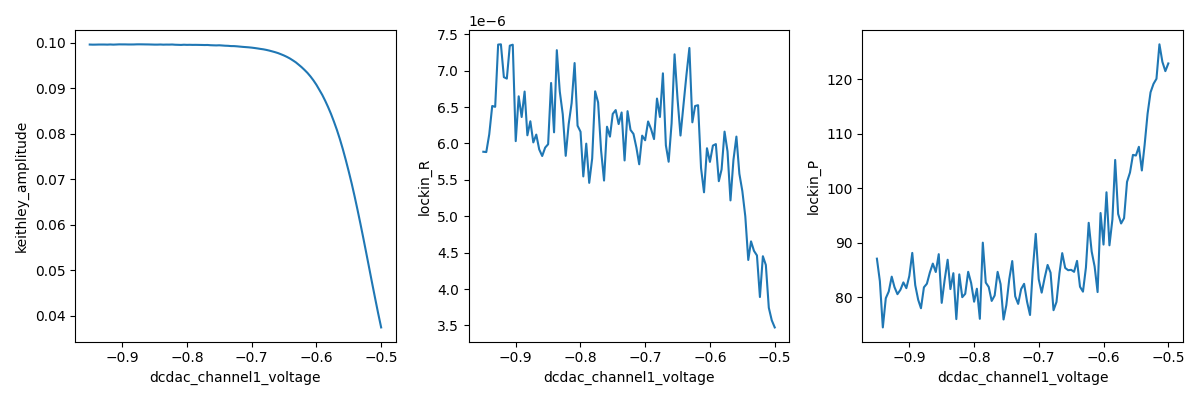

2025-02-06 14:53:58,864 [INFO] Completed in 0h 0m 58s
2025-02-06 14:53:58,864 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\2\data.tsv.gz


In [34]:
START = -0.5
STOP = -0.95
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

lockin not reading any signficiant ac excitations. 
dc voltage also plateaued. Change range 0-> -0.7

In [36]:
Vgamp(-0.5)

In [37]:
Vgres(-0.7)

2025-02-06 14:59:16,086 [INFO] Starting sweep with ID 3
2025-02-06 14:59:16,086 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

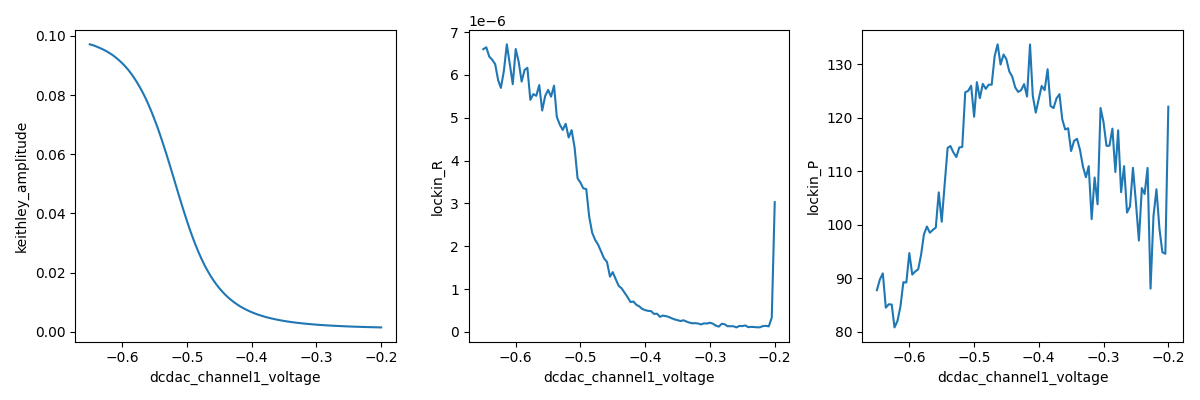

2025-02-06 15:00:14,158 [INFO] Completed in 0h 0m 57s
2025-02-06 15:00:14,158 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\3\data.tsv.gz


In [38]:
START = -0.2
STOP = -0.65
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

lockin amplitude should have peaked at inflection point of left graph. 
Possible Issue: vgamp and vgres not at constant difference -> changes resistance across HEMT_R over sweep. 

Add 100M resitor before Vgamp to ensure minimum resistance met

In [39]:
paramp(Vgamp)

In [41]:
paramp((Vgres, V1pf.voltage,Vlref.voltage))

In [43]:
paramp(Vdd)

Trying again with 100Mohm resistor

In [ ]:
V1pf.voltage(100)
Vlref.voltage(400)

In [46]:
Vgres(-0.7)

2025-02-06 15:10:10,533 [INFO] Starting sweep with ID 4
2025-02-06 15:10:10,534 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

2025-02-06 15:10:17,458 [WARNING] ID 4 INTERRUPTED


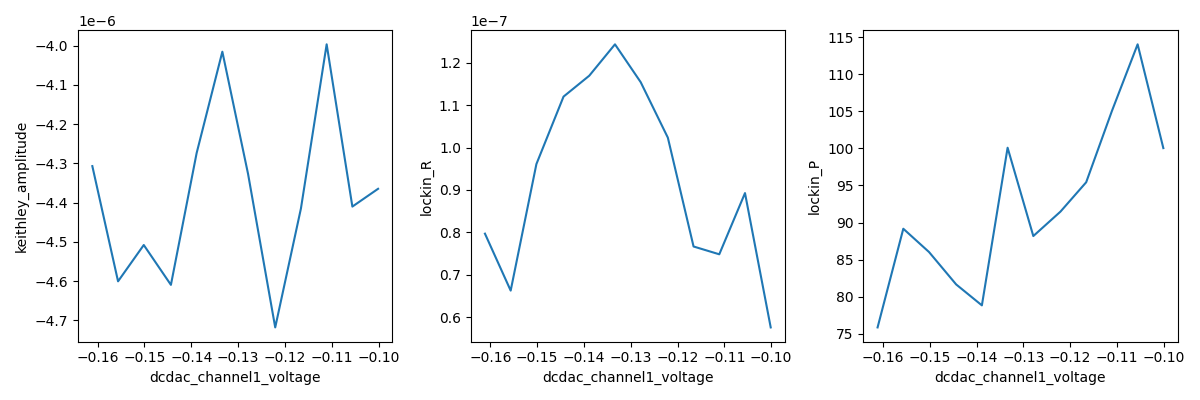

2025-02-06 15:10:17,757 [INFO] Completed in 0h 0m 6s
2025-02-06 15:10:17,758 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\4\data.tsv.gz


In [48]:
START = -0.1
STOP = -0.65
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

didnt set Vdd

In [49]:
Vdd(0.1)

In [53]:
indep_params = [Vgamp]
dep_params = [Vdsdc,Vdsac_R, Vdsac_P]

mc = {}
for param in indep_params + dep_params:
    mc[param.full_name] = param.label

s = sweep.Station(basedir=data2path,measurement_config=mc)
for param in indep_params + dep_params:
    s.fp(param)

s.add_comment("Vg sweep")

for dep in dep_params:
    s.plot(Vgamp, dep)

2025-02-06 15:11:59,516 [INFO] Starting sweep with ID 5
2025-02-06 15:11:59,517 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

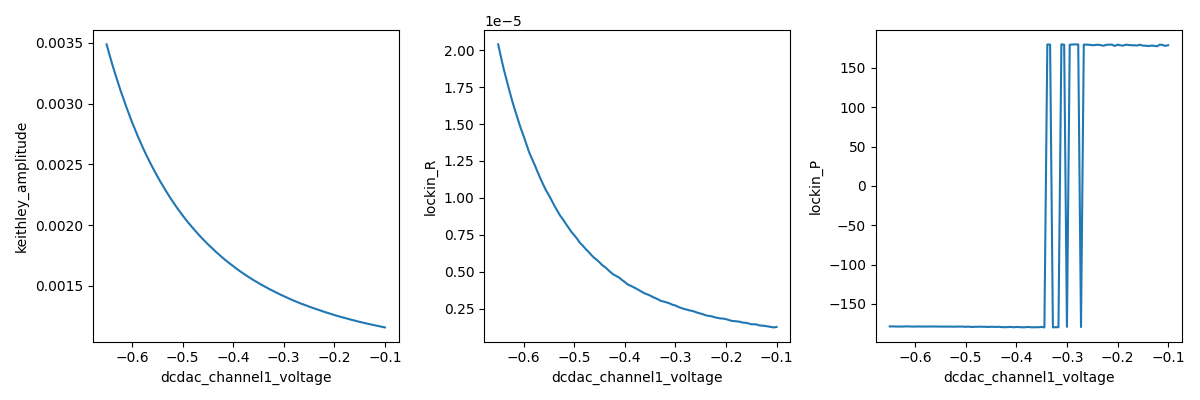

2025-02-06 15:12:58,081 [INFO] Completed in 0h 0m 58s
2025-02-06 15:12:58,081 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\5\data.tsv.gz


In [54]:
START = -0.1
STOP = -0.65
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

In [55]:
Vgres(-1)

2025-02-06 15:14:17,576 [INFO] Starting sweep with ID 6
2025-02-06 15:14:17,576 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

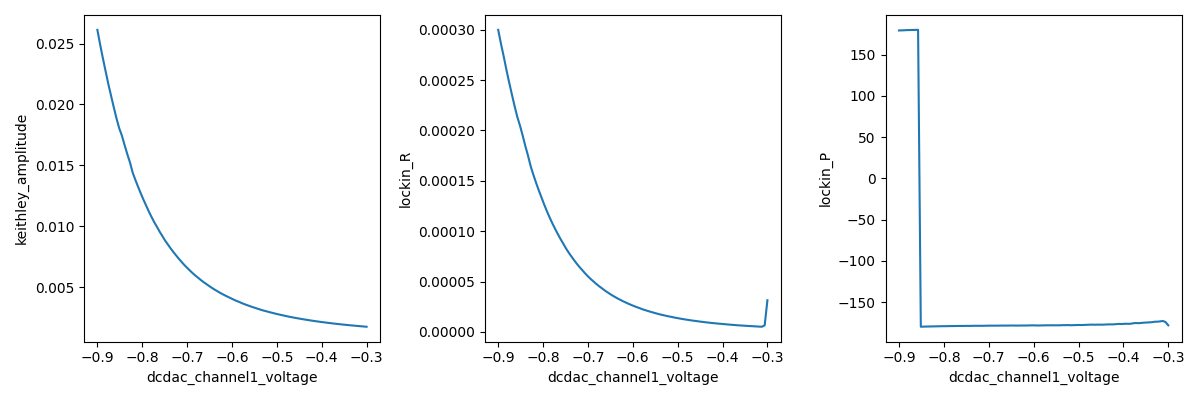

2025-02-06 15:15:15,701 [INFO] Completed in 0h 0m 57s
2025-02-06 15:15:15,702 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\6\data.tsv.gz


In [56]:
START = -0.3
STOP = -0.9
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

In [57]:
Vgres(-1.3)

In [58]:
Vgamp(-0.9)

2025-02-06 15:18:10,817 [INFO] Starting sweep with ID 7
2025-02-06 15:18:10,817 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

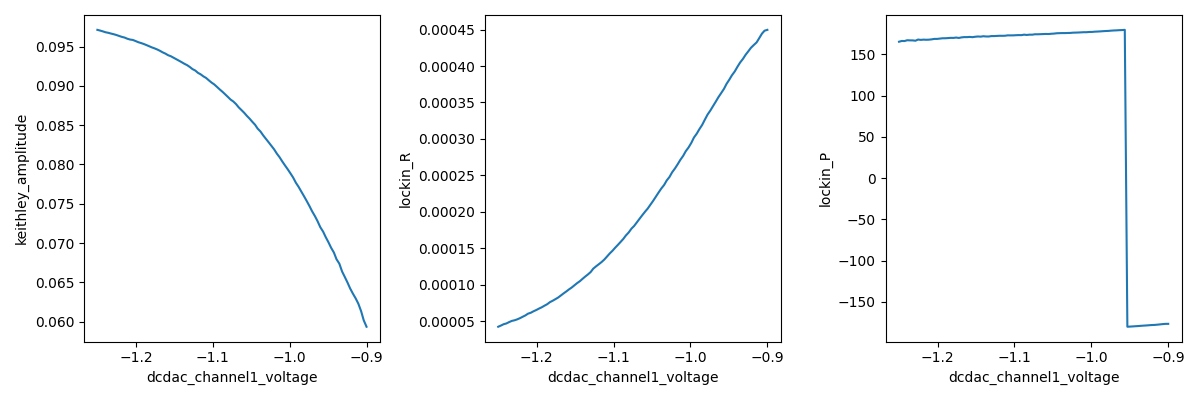

2025-02-06 15:19:08,738 [INFO] Completed in 0h 0m 57s
2025-02-06 15:19:08,738 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\7\data.tsv.gz


In [59]:
START = -0.9
STOP = -1.25
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

In [60]:
Vgamp(-0.7)

In [61]:
Vgres(-1)

In [62]:
Vgamp(), Vgres()

(-0.700095, -1.0)

2025-02-06 16:08:39,647 [INFO] Starting sweep with ID 8
2025-02-06 16:08:39,647 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

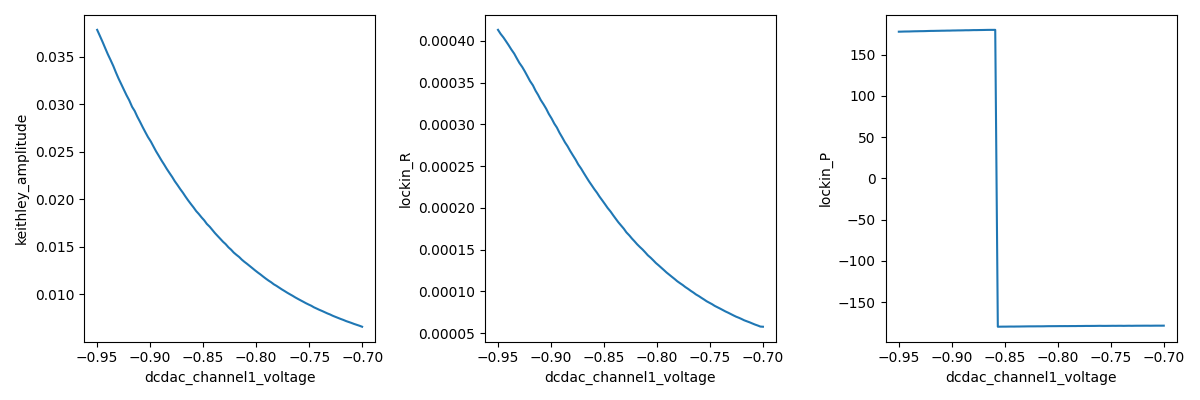

2025-02-06 16:09:37,707 [INFO] Completed in 0h 0m 57s
2025-02-06 16:09:37,707 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\8\data.tsv.gz


In [68]:
START = -0.7
STOP = -0.95
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

In [69]:
Vgres(-1.2)

2025-02-06 16:10:56,017 [INFO] Starting sweep with ID 9
2025-02-06 16:10:56,017 [INFO] Minimum duration 0h 0m 50s


  0%|          | 0/100 [00:00<?, ?it/s]

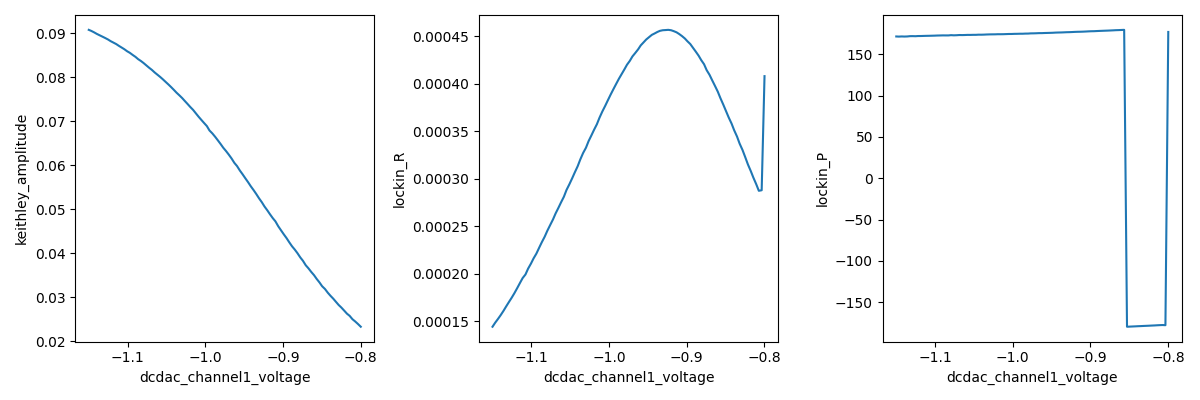

2025-02-06 16:11:53,972 [INFO] Completed in 0h 0m 57s
2025-02-06 16:11:53,972 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\9\data.tsv.gz


In [70]:
START = -0.8
STOP = -1.15
SAMPLES = 100
INT_TIME = 0.5

setpoints = np.linspace(START, STOP, SAMPLES)
res = s.sweep(Vgamp,setpoints, delay=INT_TIME)

In [71]:
# Look at result metadate for verification 
from sweep.sweep_load import pload1d

data = pload1d(data2path, 9)
liR= data[li1.R.full_name]
Vgs = data[Vgamp.full_name]

dc_bias = Vgs[np.argmax(liR)]

In [76]:
dc_bias, Vgres(), Vgamp()

(np.float64(-0.923795), -1.2, -1.149937)

In [77]:
keithley.amplitude()

0.09080564

In [78]:
Rh = Vdsdc() / (0.009e-3)
Rh

10081.724444444444

In [84]:
sys_paramp()

Ramping down Vgamp ...
Ramping down ac voltages ...
Ramping down Vdd and Vgres ...


In [90]:
toggle_yoko(False)

### Frequency Curves 

In [5]:
from constants import * 
DC_BIAS_AMP

-0.923795

In [6]:
V1pf.voltage(200)
Vlref.voltage(400)

In [7]:
Vdd(0.1)

Note, had to restart kernel because DC box wasn't able to communicate after power cycling

In [8]:
Vgamp(), Vgres()

(0.0, 0.0)

In [9]:
Vgres(DC_BIAS_AMP - 0.05)

In [10]:
Vgamp(DC_BIAS_AMP)

In [44]:
NUM_VGRES_POINTS = 15
vgres_setpoints = np.linspace(DC_BIAS_AMP - 0.05, DC_BIAS_AMP - 0.8, NUM_VGRES_POINTS)
vgres_setpoints

array([-0.973795  , -1.02736643, -1.08093786, -1.13450929, -1.18808071,
       -1.24165214, -1.29522357, -1.348795  , -1.40236643, -1.45593786,
       -1.50950929, -1.56308071, -1.61665214, -1.67022357, -1.723795  ])

In [45]:
indep_params = [acdac.frequency]
dep_params = [li1.R, li1.P]

In [46]:
Vgamp(), Vgres()

(-0.923795, -1.7238)

In [47]:
# sweep frequency settings
START = 10
STOP = 100e3
SAMPLES = 1000
INT_TIME = 1    # 3 x (li time constant = 300ms)


2025-02-06 17:37:39,299 [INFO] Starting sweep with ID 17
2025-02-06 17:37:39,299 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

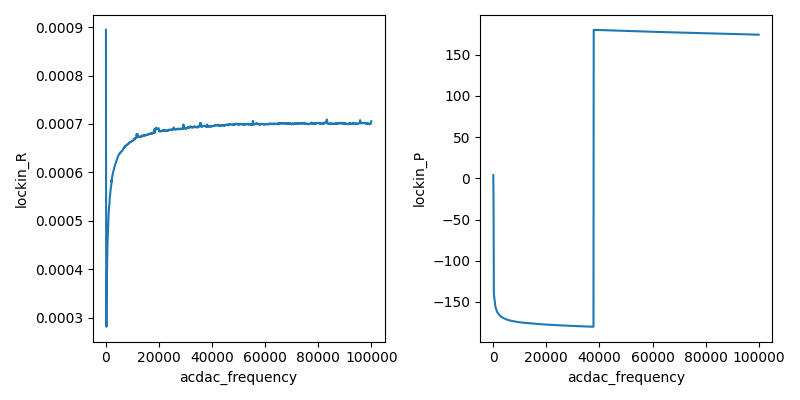

2025-02-06 17:55:04,665 [INFO] Completed in 0h 17m 25s
2025-02-06 17:55:04,665 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\17\data.tsv.gz
2025-02-06 17:55:04,678 [INFO] Starting sweep with ID 18
2025-02-06 17:55:04,679 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 18:12:30,248 [INFO] Completed in 0h 17m 25s
2025-02-06 18:12:30,248 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\18\data.tsv.gz
2025-02-06 18:12:30,255 [INFO] Starting sweep with ID 19
2025-02-06 18:12:30,255 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 18:29:55,874 [INFO] Completed in 0h 17m 25s
2025-02-06 18:29:55,875 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\19\data.tsv.gz
2025-02-06 18:29:55,882 [INFO] Starting sweep with ID 20
2025-02-06 18:29:55,883 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 18:47:21,396 [INFO] Completed in 0h 17m 25s
2025-02-06 18:47:21,397 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\20\data.tsv.gz
2025-02-06 18:47:21,404 [INFO] Starting sweep with ID 21
2025-02-06 18:47:21,405 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 19:04:47,054 [INFO] Completed in 0h 17m 25s
2025-02-06 19:04:47,054 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\21\data.tsv.gz
2025-02-06 19:04:47,063 [INFO] Starting sweep with ID 22
2025-02-06 19:04:47,063 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 19:22:12,633 [INFO] Completed in 0h 17m 25s
2025-02-06 19:22:12,633 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\22\data.tsv.gz
2025-02-06 19:22:12,645 [INFO] Starting sweep with ID 23
2025-02-06 19:22:12,646 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 19:39:38,440 [INFO] Completed in 0h 17m 25s
2025-02-06 19:39:38,440 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\23\data.tsv.gz
2025-02-06 19:39:38,460 [INFO] Starting sweep with ID 24
2025-02-06 19:39:38,461 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 19:57:04,271 [INFO] Completed in 0h 17m 25s
2025-02-06 19:57:04,271 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\24\data.tsv.gz
2025-02-06 19:57:04,279 [INFO] Starting sweep with ID 25
2025-02-06 19:57:04,279 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 20:14:29,723 [INFO] Completed in 0h 17m 25s
2025-02-06 20:14:29,723 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\25\data.tsv.gz
2025-02-06 20:14:29,730 [INFO] Starting sweep with ID 26
2025-02-06 20:14:29,731 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 20:31:55,045 [INFO] Completed in 0h 17m 25s
2025-02-06 20:31:55,045 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\26\data.tsv.gz
2025-02-06 20:31:55,058 [INFO] Starting sweep with ID 27
2025-02-06 20:31:55,059 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 20:49:20,745 [INFO] Completed in 0h 17m 25s
2025-02-06 20:49:20,745 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\27\data.tsv.gz
2025-02-06 20:49:20,757 [INFO] Starting sweep with ID 28
2025-02-06 20:49:20,758 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 21:06:46,569 [INFO] Completed in 0h 17m 25s
2025-02-06 21:06:46,569 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\28\data.tsv.gz
2025-02-06 21:06:46,577 [INFO] Starting sweep with ID 29
2025-02-06 21:06:46,577 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 21:24:12,521 [INFO] Completed in 0h 17m 25s
2025-02-06 21:24:12,521 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\29\data.tsv.gz
2025-02-06 21:24:12,529 [INFO] Starting sweep with ID 30
2025-02-06 21:24:12,530 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 21:41:38,327 [INFO] Completed in 0h 17m 25s
2025-02-06 21:41:38,327 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\30\data.tsv.gz
2025-02-06 21:41:38,334 [INFO] Starting sweep with ID 31
2025-02-06 21:41:38,335 [INFO] Minimum duration 0h 16m 40s


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-02-06 21:59:04,532 [INFO] Completed in 0h 17m 26s
2025-02-06 21:59:04,535 [INFO] Data saved in C:\Users\barreralab\OneDrive - University of Toronto\Documents\capacitance_exps\data2\31\data.tsv.gz


In [48]:
# container for measurement ids during artificial 2d sweep
data_id = -1 

for pt in vgres_setpoints:
    Vgres(pt)

    # measurement config for analysis 
    mc = {}
    for param in indep_params + dep_params:
        mc[param.full_name] = param.label

    s = sweep.Station(basedir=data2path, measurement_config=mc)
    for param in indep_params + dep_params:
        s.fp(param)

    s.add_comment(f"Transfer function for Vgres = {pt}")

    # only live plot first dataset
    if data_id < 0:
        for dep in dep_params:
            s.plot(acdac.frequency, dep)

    # s.watch(delay = INT_TIME, max_duration=10)
    setpoints = np.linspace(START, STOP, SAMPLES)
    res = s.sweep(acdac.frequency, setpoints, delay=INT_TIME)

    # save initial id for future reference 
    if data_id < 0:
        data_id = res.id 


In [53]:
data_id, len(vgres_setpoints)

(17, 15)

Note: forgot to record vgres_setpoint in each dataset. Should've been stored somewhere.

done, feb 7th 12:15 

In [49]:
sys_paramp()

Ramping down Vgamp ...
Ramping down ac voltages ...
Ramping down Vdd and Vgres ...
System shut down


In [50]:
toggle_yoko(False)

analysis in [notebooks/analysis/dual_hemt_bode.ipynb](../../analysis/dual_hemt_bode.ipynb)

Restarted Computer because wifi was disabled somehow. Had rustdesk running for remote connection during testing. Was unable to access after around 3 hours of running. Maybe wifi issue due to rustdesk. 

Replugged USB WIFI adaptor and restarted computer. Wifi enabled again. 